<a href="https://colab.research.google.com/github/MAGOUJOUGRACE/nlp/blob/main/grace_unsupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Dimension reduction, word embeddings and VAE for generating   sentences

In [ ]:
!pip install scikit-learn-extra 
!pip install umap-learn


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82830 sha256=3b1283f187b87af3f925cb62ed5e81dd83e805797e7e45601a275e33d1af5716
  Stored in directory: /root/.cache/pip/wheels/f4/3e/1c/596d0a463d17475af648688443fa4846fef624d1390339e7e9
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55509 sha256=a89e2f2b7439f5e3ebf48cb406b3cd9b08595c4500abf68ccf9a99e7c9c89354
  Stored in directory: /root/.cache/pip/wheels/b9/89/cc/5

In [ ]:
from sklearn.datasets import fetch_20newsgroups
import seaborn as sns
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn.utils
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import numpy as np
from sklearn_extra.cluster import KMedoids
import random
import string
from collections import defaultdict
from wordcloud import WordCloud
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.manifold import TSNE
import umap
from nltk.tokenize import word_tokenize
import gensim
import nltk
nltk.download('punkt')
nltk.download('stopwords')

## Data Representation

1. Importer les données

In [ ]:
df = fetch_20newsgroups(subset = 'all')



2.   Convertir les données en format TF-IDF



*  Dans l'etude d'un document traitant d'un sujet precis, on s'attend à ce 
   que certain mots se repétent plus que d'autre. La représentation TF (  Term Frequency) pondère les mots proportionnellement à leur fréquence. Elle est calculé par : $$ tf_{ij}= \log(n_{ij} +1) $$ Où $n_{ij}$ est le nombre du mot $j$ dans le document $i$.

*  De même, les mots fréquents n'ajoutent pas grand chose à notre comprehension d'un document contrairement aus mots rarent. Pour donner de l'importance aux mots les moins fréquents, on utilise la representation IDF(Inverse Document ­Frequency) calculé comme suit : $$idf_{ij} =\log(\frac{N}{df_j})$$  Où $df_j$ est le nombre de document où le terme j apparait et $N$ le nombre total de documents.


La représentation TF-IDF est simplement le produit: $$ tf-idf_{ij}= tf_{ij} \times idf_{ij}$$.

Le code qui suit permet de génerer l a représentation TF-IDF en utilisant 
 ***scikit­-learn***.





In [ ]:
vectorizer = TfidfVectorizer(strip_accents='unicode', stop_words='english') 
tfidf = vectorizer.fit_transform(df.data)

In [ ]:
print(tfidf.shape)

(18846, 173440)



3. implementer une matrice de similarités entre un échantillon aléatoire stratifié de 1000  documents utilisant la corrélation (similarité cosinus).

Il existe plusieurs mésures de similarités. Ici nous allons utiliser celle dit **cosine similarity** calculée comme suit : $$ cosine(w,c) = \frac{w^Tc}{||w|| ×||c||} $$

Elle s'interprète comme etant le coefficient de correlation entre deux documents;

* On commence par recupérer un echantillon aleatoire stratifié de 1000 documents 

In [ ]:
df_full = pd.DataFrame()
df_full['text'] = df.data
df_full['source'] = df.target
label=[]
for i in df_full['source']:
    label.append(df.target_names[i])
df_full['label']=label

In [ ]:
N = len(df_full)
df_full.head()

,text,source,label
0,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...,10,rec.sport.hockey
1,From: mblawson@midway.ecn.uoknor.edu (Matthew ...,3,comp.sys.ibm.pc.hardware
2,From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject...,17,talk.politics.mideast
3,From: guyd@austin.ibm.com (Guy Dawson)\nSubjec...,3,comp.sys.ibm.pc.hardware
4,From: Alexander Samuel McDiarmid <am2o+@andrew...,4,comp.sys.mac.hardware


In [ ]:
df_strat =  df_full.groupby('label', group_keys=False).apply(lambda x: x.sample(frac=1000/N))
df_strat =  sklearn.utils.shuffle(df_strat)
print(len(df_strat))
df_strat.head()

1000


,text,source,label
14231,From: bd@fluent@dartmouth.EDU (Brice Dowaliby)...,16,talk.politics.guns
11905,From: mccall@mksol.dseg.ti.com (fred j mccall ...,14,sci.space
13153,From: mstern@lindsay.Princeton.EDU (Marlene J....,13,sci.med
5027,From: barring@cs.washington.edu (David Barring...,9,rec.sport.baseball
5160,From: thf2@kimbark.uchicago.edu (Ted Frank)\nS...,9,rec.sport.baseball


* On convertit sous le format TF-IDF

In [ ]:
tfidf_strat = vectorizer.fit_transform(df_strat['text'])

In [ ]:
tfidf_strat.shape

(1000, 31462)

* On implemente la matrice de similatrité 

In [ ]:
sim_cos = sklearn.metrics.pairwise.cosine_similarity(tfidf_strat,tfidf_strat)

In [ ]:
sim_cos.shape

(1000, 1000)

In [ ]:
sim_cos

array([[1.        , 0.0123752 , 0.01939228, ..., 0.01106345, 0.02461598,
        0.0459659 ],
       [0.0123752 , 1.        , 0.01502557, ..., 0.00356276, 0.01083408,
        0.00319971],
       [0.01939228, 0.01502557, 1.        , ..., 0.00662097, 0.01725918,
        0.01380989],
       ...,
       [0.01106345, 0.00356276, 0.00662097, ..., 1.        , 0.01113655,
        0.01105076],
       [0.02461598, 0.01083408, 0.01725918, ..., 0.01113655, 1.        ,
        0.00442931],
       [0.0459659 , 0.00319971, 0.01380989, ..., 0.01105076, 0.00442931,
        1.        ]])

4. Échantillonnez 500 mots de vos 1000 documents  et calculer une matrice de cooccurrence de mots.

* On commence par retirer les ponctuations.

In [ ]:
for i in range(1000):
  for c in string.punctuation:
    df_strat.iloc[i,0] = df_strat.iloc[i,0].replace(c," ")


In [ ]:
df_strat.head()

,text,source,label
17396,From timbol netcom com Mike Timbol \nSubject...,2,comp.os.ms-windows.misc
13860,Organization City University of New York\nFro...,19,talk.religion.misc
17634,From clldomps cs ruu nl Louis van Dompselaar...,1,comp.graphics
1878,From gld cunixb cc columbia edu Gary L Dare ...,10,rec.sport.hockey
11861,From bob1 cos com Bob Blackshaw \nSubject R...,17,talk.politics.mideast


* On extrait les mots 

In [ ]:
# Liste vide pour stocker les mots extraits
word_list = []

# Boucle pour extraire des mots aléatoires dans chaque document
for i in range(100):
  # parcourir chaque document
  content = df_strat.iloc[i,0]
  content = content.lower()
  # Tokenisation du contenu en mots
  words = content.split()
  # recuperation d'uN indice au hazards
  
  r_i = range(len(words))

  r = random.sample(r_i,1)[0]
  # recuperation des 5 mots voisins
  random_words = words[r:r+5] 
  word_list.extend(random_words)
  

# Impression des 500 mots extraits
print(word_list)

['to', 'gain', 'if', 'he', 'gives', 'blood', 'enjoyed', 'by', 'the', 'worshippers', 'dm', 'edu', 'reply', 'to', 'gld', 'cunixb', 'bosnia', 'keywords', 'barbarism', 'organization', 'corporation', 'tc', 'umn', 'edu', 'subject', '16', 'as', 'an', 'instrument', 'of', 'control', 'the', 'last', '6', 'months', 'or', 'was', 'raised', 'by', 'a', 'pack', 'reaction', 'when', 'i', 'have', 'been', 'we', 'see', 'and', 'thus', 'what', 'the', 'other', 'day', 'i', 'was', 'melbourne', 'australia', 'my', 'opinions', 'are', 'charon', 'amdahl', 'com', 'tb', 'subject', 'ernie', 'smith', 'she', 'has', 'this', 'in', 'common', 'rfelixc5sjpe', 'bq8', 'netcom', 'com', '1r1d62', '040493023201', 'stiles', '42', 'kstar', 'node', 'well', 'a', 'lot', 'nervous', 'mainly', 'that', 'went', 'across', 'the', 'street', 'established', 'in', 'his', 'last', 'two', 'matter', 'and', 'vasomotor', 'rhinitis', 'basically', 'vasomotor', 'weaponry', 'than', 'standard', 'issue', 'handguns', 'third', 'they', 'said', 'the', 'caps', 'gu

* On implemente la matrice de cooccurrence des mots



In [ ]:
# Création de la matrice de cooccurrence
vocab = sorted(word_list)
matrix = np.zeros((len(vocab), len(vocab)))
#comptage des cooccurrences
cooccur_dict = defaultdict(int)
for i, word in enumerate(word_list):
  for j in range(max(i - 2, 0), min(i + 3, len(word_list))):
    if i!=j:
      cooccur_dict[(word, word_list[j])] += 1
# Création de la matrice de cooccurrence
for i, word in enumerate(vocab):
        for j, word1 in enumerate(vocab):
            if (word, word1) in cooccur_dict:
                matrix[i, j] = cooccur_dict[(word, word1)]      



Utilisez l'algorithme k-medoids pour regrouper les documents en 20 classes.

In [ ]:
KMobj = KMedoids(n_clusters=20).fit(tfidf_strat)

In [ ]:
centroids = KMobj.cluster_centers_.toarray().argsort()[:, ::-1] 
terms = vectorizer.get_feature_names_out()
def frequencies_dict(cluster_index):
    term_frequencies = KMobj.cluster_centers_.toarray()[cluster_index]
    sorted_terms = centroids[cluster_index]
    frequencies = {terms[i]: term_frequencies[i] for i in sorted_terms}
    return frequencies

def makeImage(frequencies):

    wc = WordCloud(background_color="white", max_words=50)
    # genéré les mots
    wc.generate_from_frequencies(frequencies)

  
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()    

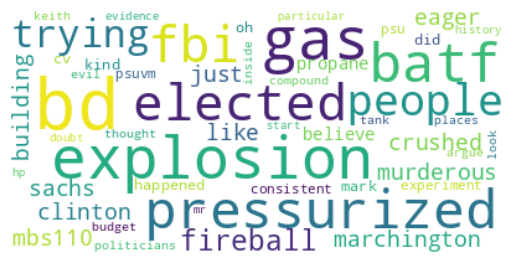

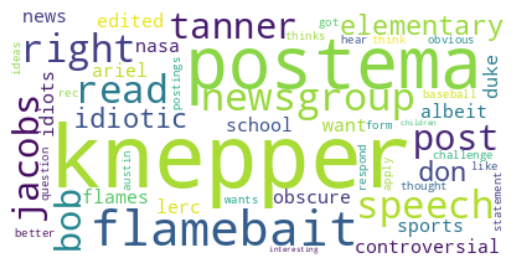

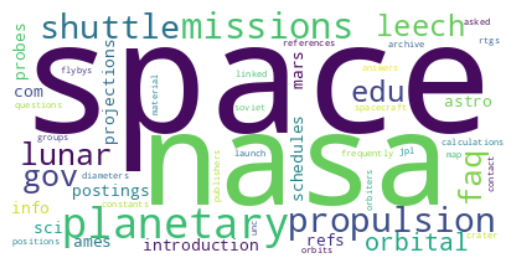

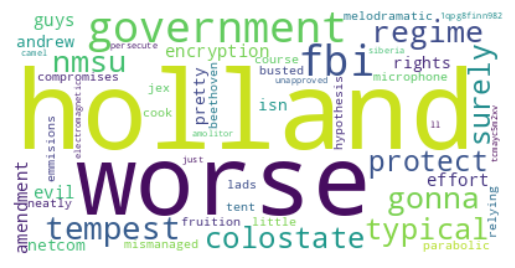

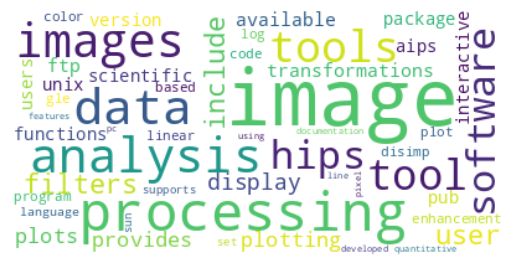

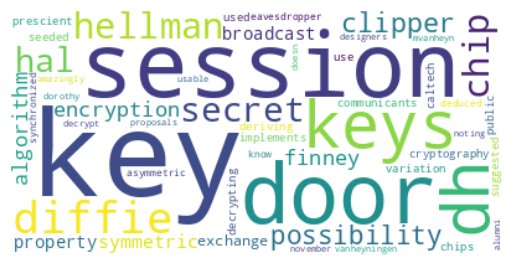

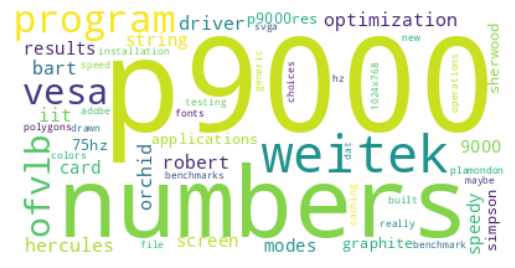

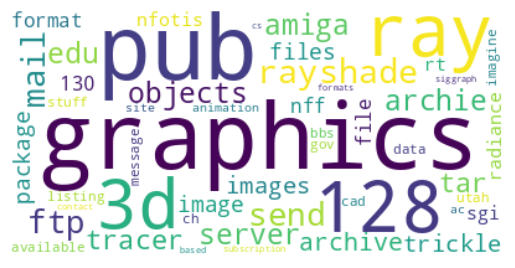

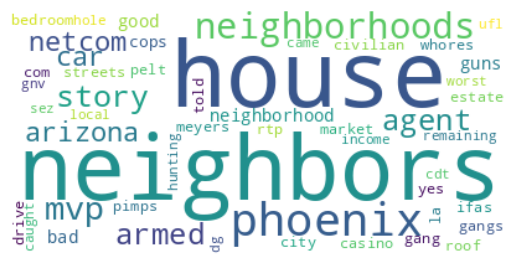

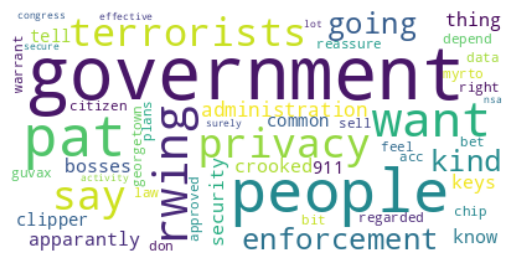

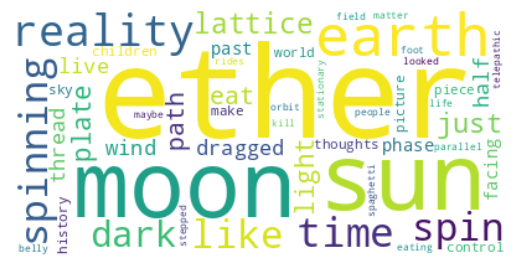

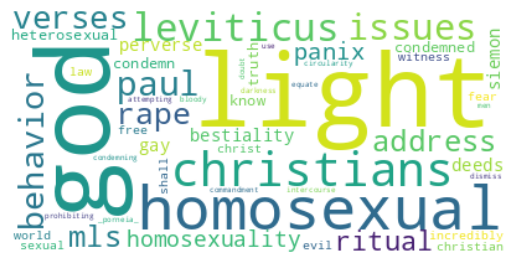

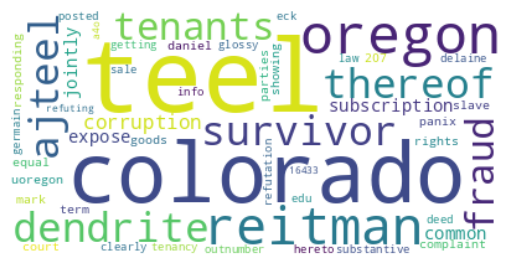

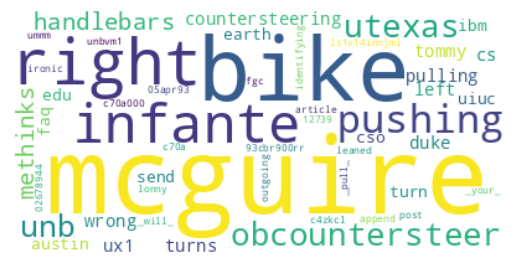

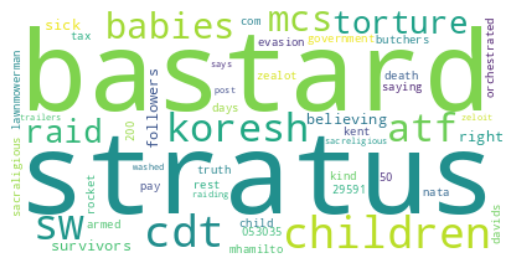

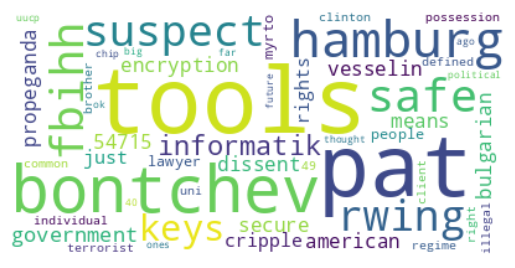

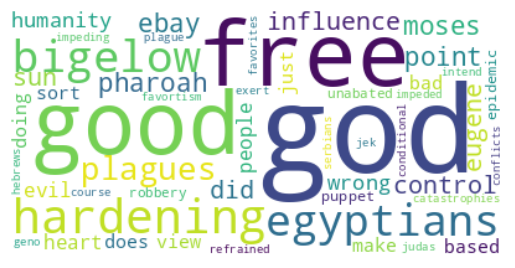

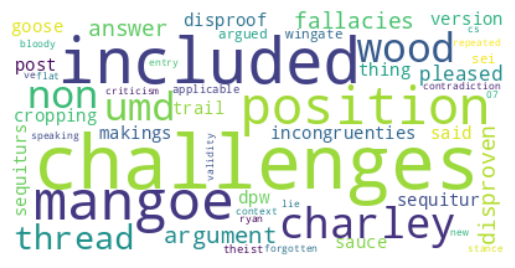

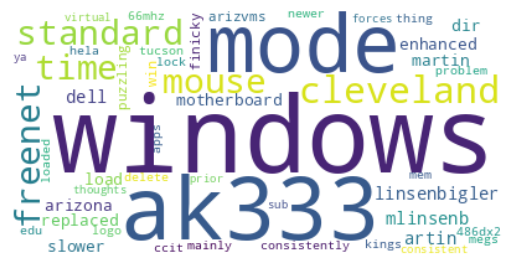

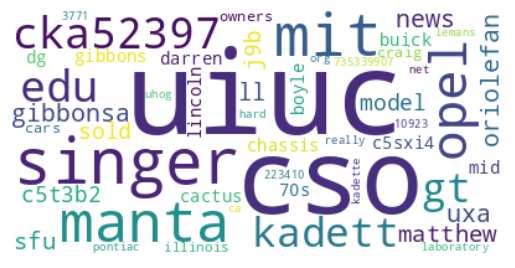

In [ ]:
for i in range(20):
    freq = frequencies_dict(i)
    makeImage(freq)
    print()

Représenter des mots et des documents en utilisant SVD (Latent Semantic Analysis), t-SNE et UMAP

L'analyse sémantique latente (LSA) est utilisée dans le traitement du langage naturel pour analyser et comprendre les relations entre un ensemble de documents et les termes qu'ils contiennent. Il est basé sur le principe que les mots qui apparaissent dans des contextes similaires ont tendance à avoir des significations similaires.

L'analyse sémantique latente est basée sur l'algorithme de décomposition en valeurs singulières.

La décomposition en valeurs singulières consiste a representé un matrice comme le produit de 3 matrices:

En effet, soit $X_{n\times d} \in \mathbf{R}^{n\times d}$, alors il existe deux matrices orthogonales $U \in \mathbf{R}^{n\times n}$ et $V \in \mathbf{R}^{n\times d}$, et une matrice diagonale non négative $S \in \mathbf{R}^{n\times d}$ telque : $$ X_{n\times d} = U_{n\times n}S_{n\times d}V_{d\times d} $$
Avec $U^TU=I$ et $V^TV=I$

Si On pose r le rand de la matrice $X_{n\times d}$ , alors on optient une version de cette decomposition appelé **truncated  SVD**   qui suit:  $$ X_{n\times d} = U_{n\times n}S_{r\times r}V_{r\times d} $$

In [ ]:
svd= TruncatedSVD(20)
lsa = make_pipeline(svd, Normalizer(copy=False))
news_group_lsa = lsa.fit_transform(tfidf_strat)



 t-SNE ermet de représenter des points de données de grande dimension dans un espace à deux ou trois dimensions, tout en préservant la structure locale des données. Ceci est réalisé en définissant une distribution de probabilité sur des paires d'objets de grande dimension de telle sorte que des objets similaires ont une probabilité plus élevée d'être sélectionnés que des objets non similaires.

Dans l'espace de faible dimension, t-SNE minimise la divergence de Kullback-Leibler entre la distribution de probabilité sur des paires de points dans l'espace de grande dimension et la distribution de probabilité sur des paires de points dans l'espace de faible dimension. Le résultat est un ensemble de points dans l'espace de faible dimension qui représente les données de grande dimension d'une manière qui préserve la structure initiales des données.

In [ ]:
tsne_lsa = TSNE().fit_transform(news_group_lsa)


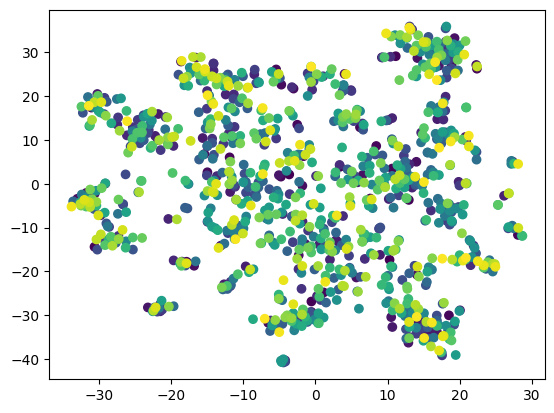

In [ ]:

plt.scatter(tsne_lsa[:,0], tsne_lsa[:,1], c =np.linspace(0,1, 1000))
plt.title("")
plt.show()

UMAP (Uniform Manifold Approximation and Projection) est une technique d'apprentissage automatique utilisée pour la réduction de la dimensionnalité, le regroupement et la visualisation de données de grande dimension.

UMAP travaille  avec les similarités et utilise la cross entropie comme critère d'optimisation.

UMAP est souvent considéré comme produisant des
résultats plus stable et consistent que t-SNE,
surtout lorsqu'il s'agit de grands ensembles de données.

In [ ]:
umap_lsa = umap.UMAP().fit_transform(news_group_lsa)

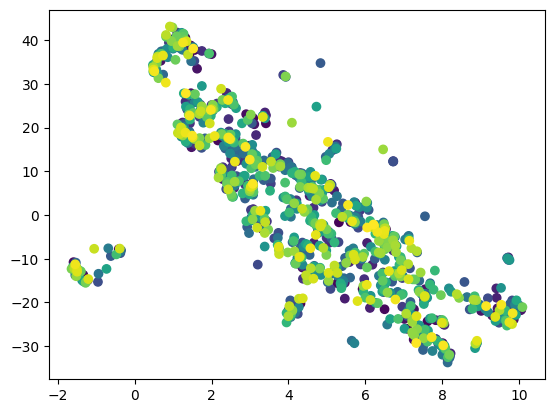

In [ ]:
plt.scatter(umap_lsa[:,0], tsne_lsa[:,1], c =np.linspace(0,1, 1000))
plt.title("")
plt.show()

Utilisez word2vec pour créer des incorporations de mots, puis visualisez à l'aide de t-SNE et UMAP

Word2Vec est une technique puissante pour apprendre les représentations vectorielles des mots, qui peuvent capturer les relations sémantiques et syntaxiques entre les mots dans un corpus de texte.

In [ ]:
news_lines=list()
lines = df_strat['text'].values.tolist()

for line in lines:
    tokens = word_tokenize(line)
    
    tokens = [w.lower() for w in tokens]
    
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    
    words = [word for word in stripped if word.isalpha()]
    
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    news_lines.append(words)

In [ ]:
model = gensim.models.Word2Vec(sentences=news_lines, window=5, workers=4, min_count=5)

words = list(model.wv.key_to_index)
print('vocabulary size: %d' % len(words))

vocabulary size: 5155


* Obtenir les représentations vectorielles continues de chaque mot du vocabulaire du modèle

In [ ]:

words = []
embeddings = []
for word in model.wv.key_to_index:
    words.append(word)
    embeddings.append(model.wv[word])


* Réduire la dimensionnalité des plongements à l'aide de t-SNE

In [ ]:
X_tsne =  TSNE().fit_transform(np.array(embeddings))

* Visualiser les plongements à l'aide d'un nuage de points

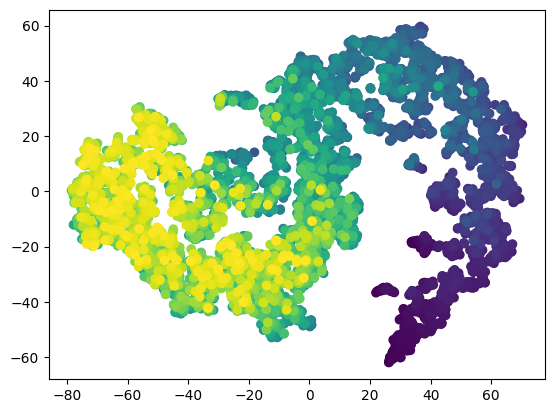

In [ ]:

plt.scatter(X_tsne[:, 0], X_tsne[:, 1],c =np.linspace(0,1, 5155))
plt.show()



* Réduire la dimensionnalité des plongements à l'aide de t-SNE

In [ ]:
umap_emb = umap.UMAP().fit_transform(embeddings)

* Visualiser les plongements à l'aide d'un nuage de points

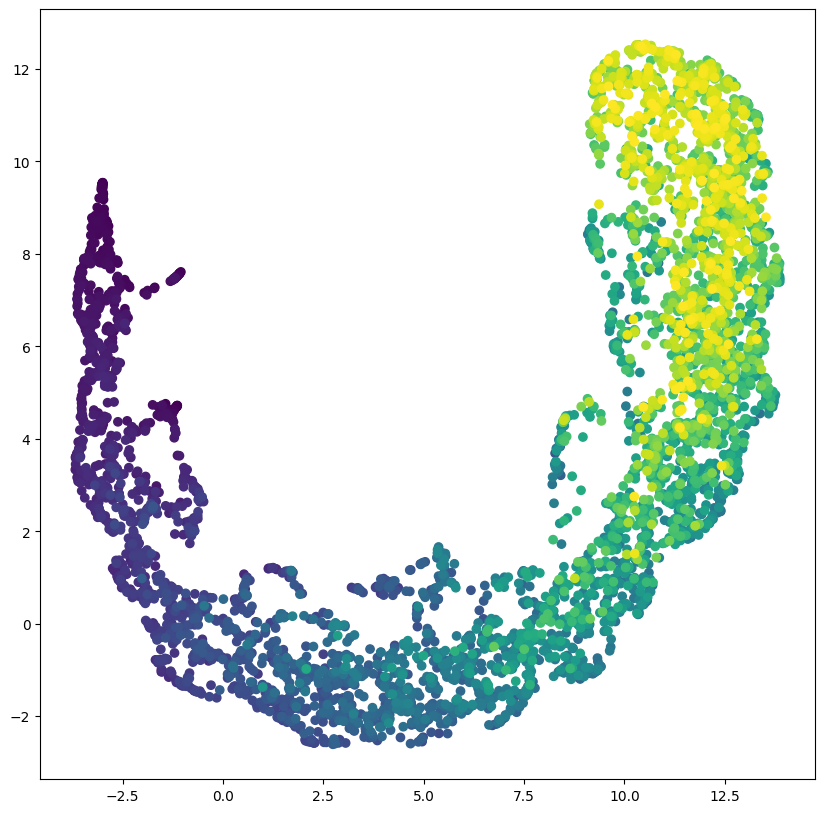

In [ ]:
plt.figure(figsize=(10, 10))
plt.scatter(umap_emb[:, 0], umap_emb[:, 1], c =np.linspace(0,1, 5155) )

plt.show()